In [1]:
import ares
import matplotlib.pyplot as plt
import numpy as np
import classy
from astropy.cosmology import Planck18_arXiv_v2 as Planck
from importlib import reload
import pickle
from millicharge import LCDM

Now we will run class for various models:

1. No DM interaction
2. DM interaction but no relative velocities
3. DM interaction & relative velocities

The following requires CLASS to be installed from kboddy/class_dmeff, dev-vrel branch

In [2]:
m_dmeff = 1.0  # GeV
sigma_dmeff = 1e-41  # cm^2
Vrel_dmeff = 30 # km/s at z ~ 1010
params = LCDM.class_params()
params.update({
    'omega_dmeff': 0.12038, 'omega_cdm': 1e-10, 'm_dmeff': m_dmeff,
    'sigma_dmeff': sigma_dmeff, 'npow_dmeff': -4, 'Vrel_dmeff': Vrel_dmeff
})

params_noVrel = params.copy()
params_noVrel['Vrel_dmeff'] = 0

params_nodm = params.copy()
params_nodm['sigma_dmeff'] = 0

print("Computing DM Class", flush=True)
cl = classy.Class()
cl.set(params)
cl.compute()

print("Computing No Vrel Class", flush=True)
cl_noVrel = classy.Class()
cl_noVrel.set(params_noVrel)
cl_noVrel.compute()

print("Computing No DM Class", flush=True)
cl_nodm = classy.Class()
cl_nodm.set(params_nodm)
cl_nodm.compute()


Computing DM Class
Computing No Vrel Class
Computing No DM Class


The following are to be passed as `cosmology_inits` (a new thing in ARES)

In [3]:
z_initial=200
z_initial=60
z_initial=60

thermo = cl.get_thermodynamics()
inputs = {
    'z': thermo['z'], 'xe': thermo['x_e'], 'Tk': thermo['Tb [K]'], 
    'Tchi': thermo['T_dmeff'], 'Vchib': Vrel_dmeff*1e5 * z_initial / 1010
}


thermo_noVrel = cl_noVrel.get_thermodynamics()
inputs_noVrel = {
    'z': thermo_noVrel['z'], 'xe': thermo_noVrel['x_e'], 'Tk': thermo_noVrel['Tb [K]'], 
    'Tchi': thermo_noVrel['T_dmeff'], 'Vchib': 0
}
    
thermo_nodm = cl_nodm.get_thermodynamics()
inputs_nodm = {
    'z': thermo_nodm['z'], 'xe': thermo_nodm['x_e'], 'Tk': thermo_nodm['Tb [K]'], 
    'Tchi': thermo_nodm['T_dmeff'], 'Vchib': 0
}


In [4]:
import os
hmf_table = os.environ['ARES'] + '/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5'

In [5]:
# No DM sim

other_params = dict(restricted_timestep=['ions', 'neutrals', 'electrons', 'temperature', 'hubble'],
                    epsilon_dt=0.05*0.02)
other_params_idm = dict(restricted_timestep=['ions', 'neutrals', 'electrons', 'temperature', 'hubble', 'idm'],
                    epsilon_dt=0.05*0.02)

sim_nodm = ares.simulations.Global21cm(
    cosmology_inits=inputs_nodm, include_dm=False, verbose=True,
    m_dmeff=m_dmeff, sigma_dmeff=0, npow_dmeff=-4,
    cosmology_name='user', hmf_table=hmf_table, initial_redshift=z_initial, 
    **other_params
)

# Vchi = 0 sim


sim_noVrel = ares.simulations.Global21cm(
    cosmology_inits=inputs_noVrel, include_dm=True, verbose=True,
    m_dmeff=m_dmeff, sigma_dmeff=sigma_dmeff, npow_dmeff=-4,
    cosmology_name='user', hmf_table=hmf_table, initial_redshift=z_initial, 
    **other_params_idm
)

# Vrel = 30 km/s at z=1010
# trying to change initial timestep here (jordan suggested)
# initial_timestep = 1e-9
initial_timestep = .001
sim = ares.simulations.Global21cm(
    cosmology_inits=inputs, include_dm=True, verbose=True,
    m_dmeff=m_dmeff, sigma_dmeff=sigma_dmeff, npow_dmeff=-4,
    cosmology_name='user', hmf_table=hmf_table, initial_timestep=initial_timestep, initial_redshift=z_initial, 
    **other_params_idm
)


##############################################################################################################
####                                      ARES Simulation: Overview                                       ####
##############################################################################################################
#### ---------------------------------------------------------------------------------------------------- ####
#### Uniform Backgrounds                                                                                  ####
#### ---------------------------------------------------------------------------------------------------- ####
####               sfrd      sed    radio    O/IR    Ly-a     LW     Ly-C   X-ray    RTE                  ####
#### pop #0  :    fcoll      yes                      x       x                                           ####
#### pop #1  : link:sfrd:0   yes                                              x                           ####


In [6]:
print("Running dm sim")
sim.run()
print("Running vchib=0 sim")
sim_noVrel.run()
print("Running nodm sim")
sim_nodm.run()

Running dm sim
/Users/tmorton/repositories/ares/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
Running vchib=0 sim
/Users/tmorton/repositories/ares/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
Running nodm sim
/Users/tmorton/repositories/ares/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.


In [11]:
# %tb

In [12]:
# sim.history

[(-600, 100), (0, 220)]

/Users/tmorton/miniconda3/envs/millicharge/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


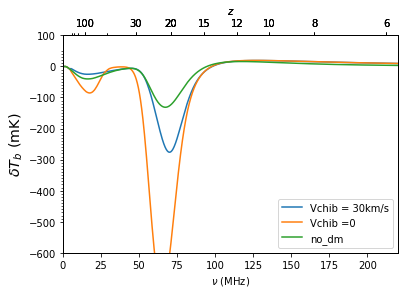

In [25]:
fig, ax = plt.subplots()
sim.GlobalSignature(ax=ax, label=r'Vchib = 30km/s')
# sim1.GlobalSignature(ax=ax, label=r'$\sigma=10^{-41}, V_{\chi^b}=2.5 \mathrm{km/s}$')
sim_noVrel.GlobalSignature(ax=ax, label=r'Vchib =0')
sim_nodm.GlobalSignature(ax=ax, label=r'no_dm')

ax.legend()
ax.set(ylim=(-600,100), xlim=(0, 220))

/Users/tmorton/miniconda3/envs/millicharge/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


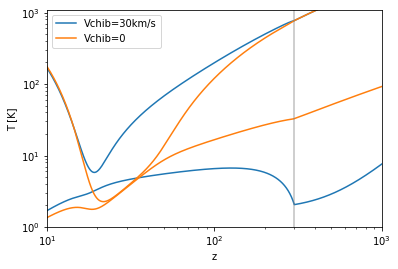

In [28]:
fig, ax = plt.subplots()

cs = ['C0', 'C1']
labels = ['Vchib=30km/s', 'Vchib=0']
lines = []
for i,s in enumerate([sim, sim_noVrel]):
# for i,s in enumerate([sim]):
    zs = s.history['z'] 
    Tb = s.history['igm_Tk']
    Tchi = s.history['igm_Tchi']
    ax.plot(zs, Tb, c=cs[i])
    l, = ax.plot(zs, Tchi, c=cs[i])
    lines.append(l)
ax.set(xscale='log', yscale='log')
ax.set(xlim=(10, 1000), ylim=(1,1100))
ax.set(xlabel='z', ylabel='T [K]')
ax.legend(lines, labels)
ax.axvline(z_initial, c='grey', alpha=0.5)

NameError: name 'sim0' is not defined

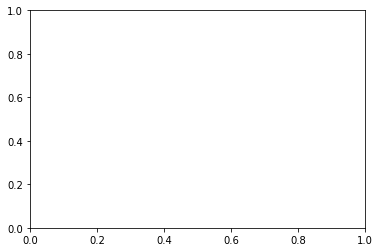

In [27]:
fig, ax = plt.subplots()

ax.plot(sim0.history['z'], sim0.history['igm_Tk'],  label=r'$\sigma_0 = 0$')
ax.plot(sim1.history['z'], sim1.history['igm_Tk'], label=r'$Vchib=2.5 km/s$')
ax.plot(sim2.history['z'], sim2.history['igm_Tk'], label=r'$Vchib=0$')
ax.axvline(60)

ax.set(yscale='log', xscale='log', xlim=(0,100),
    xlabel='z', ylabel=r'$T_k$'
)
ax.legend()
plt.show()

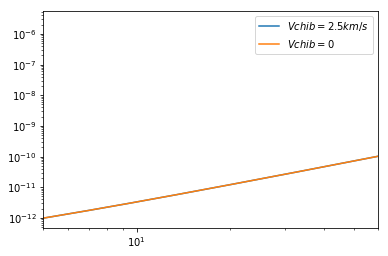

In [89]:
fig, ax = plt.subplots()

ax.plot(sim.history['z'], sim.history['igm_Tchi'], label=r'$Vchib=2.5 km/s$')
# ax.plot(sim0.history['z'], sim0.history['igm_Tchi'],  label=r'$\sigma_0 = 0$')
ax.plot(sim1.history['z'], sim1.history['igm_Tchi'], label=r'$Vchib=0$')

ax.set(yscale='log', xscale='log', xlim=(0,60))
ax.legend()
plt.show()

Text(0,0.5,'Temperature')

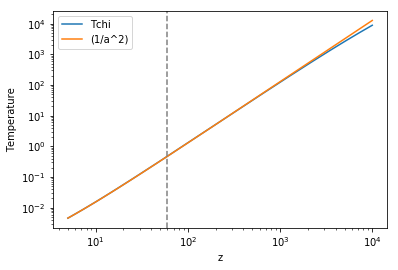

In [12]:
x = sim.history['z']
y1 = sim.history['igm_Tchi']
# y1 = sim.history['igm_Vchib']
y2 = sim.history['igm_Tk']

fig, ax = plt.subplots()
fig.patch.set_facecolor('white')

# ax.plot(x, y1 - y2)
y3 = (1+x)**2
y3 *= y1[-1] / y3[-1]

ax.plot(x, y1, label='Tchi')
# ax.set(xlim=(1,70))
# ax.plot(x, y2)
ax.plot(x, y3, label='(1/a^2)')
ax.axvline(sim.pf['initial_redshift'], ls='--', c='grey')

plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel("z")
plt.ylabel("Temperature")
# plt.savefig('figs/Tchi_sig1e-25.pdf')

In [71]:
sim.pf['initial_redshift']

60.0

Text(0,0.5,'Temperature')

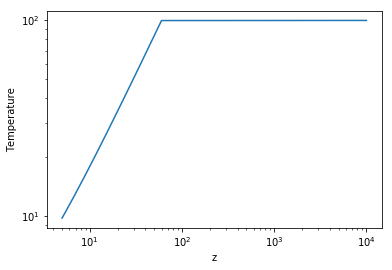

In [65]:
plt.plot(sim.history['z'], sim.history['igm_Vchib'])

# plt.xlim(0, 60)
# plt.xlim(1000, 100_000)
# plt.plot(therm['z'], therm['T_dmeff'])


plt.yscale('log')
plt.xscale('log')
plt.xlabel("z")
plt.ylabel("Temperature")

In [68]:
cl.

Docstring:
get_current_derived_parameters(names)

Return a dictionary containing an entry for all the names defined in the
input list.

Parameters
----------
names : list
        Derived parameters that can be asked from Monte Python, or
        elsewhere.

Returns
-------
derived : dict

.. warning::

    This method used to take as an argument directly the data class from
    Monte Python. To maintain compatibility with this old feature, a
    check is performed to verify that names is indeed a list. If not, it
    returns a TypeError. The old version of this function, when asked
    with the new argument, will raise an AttributeError.
Type:      builtin_function_or_method


In [9]:
sim.history

{'igm_Tk': array([27256.36275   , 27255.        , 27253.63725   , ...,
          706.83868655,   707.30383766,   707.76830964]),
 'igm_e': array([1.16374406, 1.16374406, 1.16374406, ..., 0.10078801, 0.10088932,
        0.10099056]),
 'igm_h_1': array([0.07515088, 0.07515088, 0.07515088, ..., 0.89921199, 0.89911068,
        0.89900944]),
 'igm_h_2': array([0.92484912, 0.92484912, 0.92484912, ..., 0.10078801, 0.10088932,
        0.10099056]),
 'igm_rho': array([4.19034996e-19, 4.18972148e-19, 4.18909305e-19, ...,
        1.68682037e-27, 1.68682037e-27, 1.68682037e-27]),
 'igm_n': array([4.08880481e+05, 4.08819155e+05, 4.08757835e+05, ...,
        4.54510492e-05, 4.53777115e-05, 4.53045550e-05]),
 'igm_Ja': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.42860576e-09, 4.42500299e-09, 4.42140532e-09]),
 'igm_Jlw': array([0., 0., 0., ..., 0., 0., 0.]),
 'igm_dTb': array([-1.42114776e-14,  0.00000000e+00, -1.42107671e-14, ...,
         2.60781179e+00,  2.60333967e+00,  

In [23]:
import pickle
with open('/Users/jacoblashner/cl_dmeff.pkl', 'w') as f:
    pickle.dump(cl, f)

TypeError: no default __reduce__ due to non-trivial __cinit__

In [17]:
sim = ares.simulations.Global21cm(verbose=True)
sim.run()

# Loaded $ARES/input/inits/inits_planck_TTTEEE_lowl_lowE_best.txt.

##############################################################################################################
####                                      ARES Simulation: Overview                                       ####
##############################################################################################################
#### ---------------------------------------------------------------------------------------------------- ####
#### Uniform Backgrounds                                                                                  ####
#### ---------------------------------------------------------------------------------------------------- ####
####               sfrd      sed    radio    O/IR    Ly-a     LW     Ly-C   X-ray    RTE                  ####
#### pop #0  :    fcoll      yes                      x       x                                           ####
#### pop #1  : link:sfrd:0   yes            

(1, 3000)

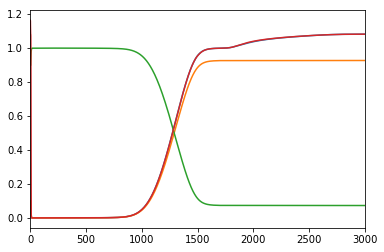

In [35]:
plt.plot(sim.history['z'], sim.history['igm_e'])
plt.plot(sim.history['z'], sim.history['igm_h_2'])
plt.plot(sim.history['z'], sim.history['igm_h_1'])
plt.plot(therm['z'], therm['x_e'])

plt.xlim(1, 3000)

In [2]:
h = Planck.h
class LCDM:
    h = h
    H0 = Planck.H0.value
    omega_b = Planck.Ob0 * h ** 2
    omega_cdm = (Planck.Om0 - Planck.Ob0) * h ** 2
    omega_nu = Planck.Onu0
    omega_k = Planck.Ok0

    m_ncdm = sum(Planck.m_nu).value
    Neff = Planck.Neff
    N_ncdm = 1
    N_ur = Planck.Neff - N_ncdm

    Tcmb = Planck.Tcmb0.value
    A_s = 2.097e-9
    tau_reio = 0.0540
    n_s = 0.9652
    YHe = 0.24537116583825905
    reion_exponent = 1.5
    reion_width = 0.5

In [37]:
class_params = {
    'h': LCDM.h, 'omega_b': LCDM.omega_b, 'omega_cdm': LCDM.omega_cdm,
    'Omega_k': LCDM.omega_k, 'N_ur': LCDM.N_ur, 'N_ncdm': LCDM.N_ncdm,
    'm_ncdm': LCDM.m_ncdm, 'A_s': LCDM.A_s, 'n_s': LCDM.n_s,
    'T_cmb': LCDM.Tcmb, 'tau_reio': LCDM.tau_reio, 'YHe': LCDM.YHe,
    'reionization_exponent': LCDM.reion_exponent,
    'reionization_width': LCDM.reion_width, 'P_k_max_1/Mpc': 200,
    'output': 'dTk,mPk,tCl',
}

dm_params = {
    'omega_dmeff': 0.12038, 'omega_cdm': 1e-10, 'm_dmeff': 1.0,
    'sigma_dmeff': 1e-23, 
    'npow_dmeff': 0,
}
cl = classy.Class()
cl.set(class_params)
cl.set(dm_params)

cl.compute()

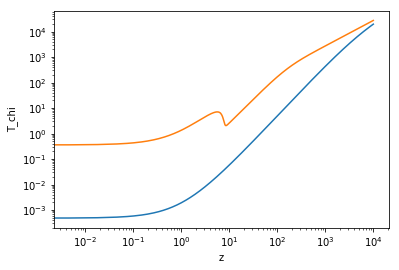

In [38]:
therm = cl.get_thermodynamics()
x = therm['z'] 
y1 = therm['T_dmeff']
y2 = therm['Tb [K]']

fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
ax.plot(x, y1)
ax.plot(x, y2)
ax.set(
#     xlim=(1000, 10_000), ylim=(1, 10_000),
    xscale='log', yscale='log',
    xlabel='z', ylabel='T_chi',
)
plt.show()


In [31]:
therm.keys()

dict_keys(['z', 'conf. time [Mpc]', 'x_e', "kappa' [Mpc^-1]", 'exp(-kappa)', 'g [Mpc^-1]', 'Tb [K]', 'c_b^2', 'tau_d', 'T_dmeff', 'rate_dmeff_mom [Mpc^-1]', "rate_dmeff_mom'", 'rate_dmeff_temp [Mpc^-1]', 'c_dmeff^2'])